In [2]:
import sys; sys.path.append("../")
from src.NasaPolynomial import NasaPolynomial
from src import constants
import torinanet as tn
import json
from scipy.stats import norm
import pandas as pd
import numpy as np
from typing import List
import matplotlib.pyplot as plt

GRAPH_NAMES = constants.GRAPH_NAMES
BASE_GRAPH_PATH = constants.BASE_LITERATURE_GRAPH_PATH
RXN_GRAPH_PARAMS = constants.RXN_GRAPH_PARAMS

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


# Specie Property Distributions

This section explores the distributions of the different thermodynamic properties of species. We explore the enthalpy, entropy and free energy. First, define a few helper functions

In [18]:
def specie_enthalpy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.h(temperature)

def specie_entropy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.s(temperature)

def specie_free_energy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.h(temperature) - temperature * poly.s(temperature)

def collect_specie_thermo_properties(rxn_graph: tn.core.RxnGraph, temperatures: List[float]) -> pd.DataFrame:
    """Collect all specie proeprties to a dataframe. calculate the properties at different temperatures"""
    data = []
    props = {
        "H": specie_enthalpy, 
        "S": specie_entropy, 
        "G": specie_free_energy
    }
    for sp in rxn_graph.species:
        for temp in temperatures:
            ajr = {"sp": sp.identifier, "T": temp}
            for name, func in props.items():
                ajr[name] = func(sp, temp)
            data.append(ajr)
    res = pd.DataFrame(data)
    res = res.set_index("sp")
    return res



Collecting all the thermodynamic specie information from all of the "literature" networks

In [19]:
df = pd.DataFrame()
temperatures = [400, 700, 1000]
for path in GRAPH_NAMES:
    g = tn.core.RxnGraph.from_file(BASE_GRAPH_PATH.replace("$", path), classargs=RXN_GRAPH_PARAMS)
    ajr = collect_specie_thermo_properties(g, temperatures)
    ajr["graph"] = path
    ajr.index = [path + "." + x for x in ajr.index]
    df = pd.concat([df, ajr])
df

,T,H,S,G,graph
ammonia.NH3,400,-42164.769903,203.639690,-123620.645880,ammonia
ammonia.NH3,700,-29092.566713,227.768089,-188530.229195,ammonia
ammonia.NH3,1000,-13377.661877,246.369094,-259746.756341,ammonia
ammonia.O2,400,3026.954075,213.876622,-82523.694597,ammonia
ammonia.O2,700,12499.679038,231.470784,-149529.869964,ammonia
...,...,...,...,...,...
methane.C3H8,700,-59300.900375,360.590081,-311713.957321,methane
methane.C3H8,1000,-11380.355412,417.227350,-428607.705084,methane
methane.H2O2,400,-131360.280071,247.535445,-230374.458228,methane
methane.H2O2,700,-115856.621842,276.195357,-309193.371977,methane


Now check the distribution of these thermodynamic properties (wrt temperature). First, we check the joint distribution regargdless of graph

,Property,Temperature,Mean,STD
0,H,400,90684.4064,202214.6783
1,H,700,104864.4256,200294.9822
2,H,1000,121404.8304,197977.8793
3,S,400,222.6374,45.3682
4,S,700,248.8371,55.7146
5,S,1000,268.4348,64.8564
6,G,400,1629.4292,208708.3038
7,G,700,-69321.5754,215220.5426
8,G,1000,-147029.9869,224158.3898


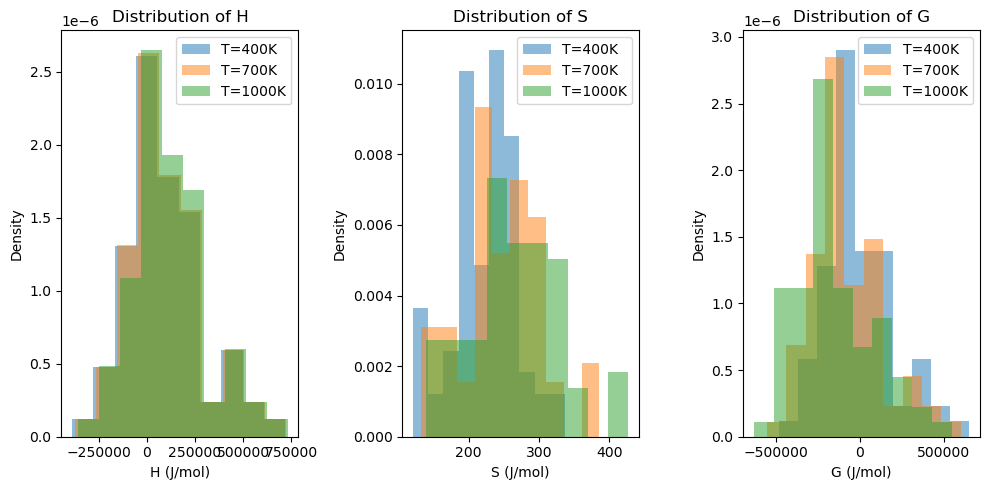

In [21]:
temps = df["T"].unique()
props = ["H", "S", "G"]
fig, axs = plt.subplots(ncols=len(props), figsize=(10, 5))
ajr = []
for i, p in enumerate(props):
    for t in temps:
        values = df[df["T"] == t][p]
        axs[i].hist(values, density=True, alpha=0.5, label=f"T={t}K")
        ajr.append([p, t, np.mean(values), np.std(values)])
        axs[i].legend()
        axs[i].set_xlabel(f"{p} (J/mol)")
        axs[i].set_ylabel("Density")
        axs[i].set_title(f"Distribution of {p.title()}")
plt.tight_layout()
ajr = pd.DataFrame(ajr, columns=["Property", "Temperature", "Mean", "STD"])
ajr.round(4)

We check if we can approximate the distribution of the enthalpy by a normal distribution

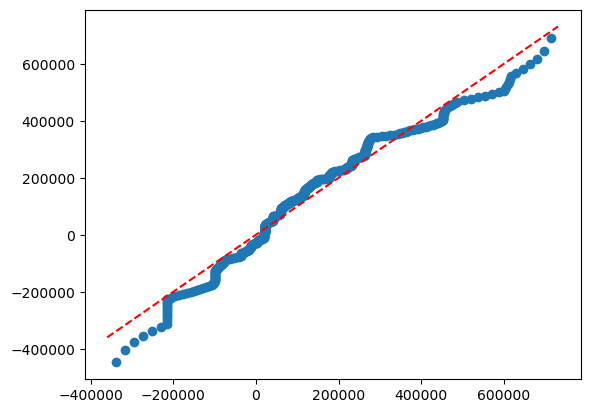

In [6]:
values = df[df["T"] == 1000]["H"]
dist = norm(np.mean(values), np.std(values))
quantiles = np.linspace(0, 100, 500)
true = np.percentile(values, quantiles)
pred = [dist.ppf(x / 100) for x in quantiles]
plt.scatter(true, pred)
plt.plot(true, true, "r--")

# Reaction Property Distributions

Analysis of reaction property distribution and their fit. we focus here on kinetic property distributions (A, beta and Ea)

In [11]:
def calculate_reaction_energy(rxn: tn.core.Reaction, specie_energy_func):
    """
    Add reaction energy based on atomization energy, species enthalpy and gibbs free energy. 
    """
    products_e = [specie_energy_func(s) for s in rxn.products]
    reactants_e = [specie_energy_func(s) for s in rxn.reactants]
    if None in products_e or None in reactants_e:
        return None
    return sum(products_e) - sum(reactants_e)

def _specie_enthalpy(temperature: float):
    return lambda sp: specie_enthalpy(sp, temperature) 

def _specie_entropy(temperature: float):
    return lambda sp: specie_entropy(sp, temperature) 

def add_reaction_energies(rxn_graph: tn.core.RxnGraph, specie_energy_funcs: dict):
    """
    Add reaction energies to the reaction graph.
    """
    for rxn in rxn_graph.reactions:
        for name, func in specie_energy_funcs.items():
            e = calculate_reaction_energy(rxn, func)
            if e is not None:
                rxn.properties[name] = e
    return rxn_graph

def estimate_reaction_kinetics(rxn_graph: tn.core.RxnGraph, default_temperature: float=1000):
    """
    Estimate reaction rate parameters
    """
    for rxn in rxn_graph.reactions:
        if not pd.isna(rxn.properties.get("rEa", pd.NA)) and \
            not pd.isna(rxn.properties.get("rA", pd.NA)) and \
            not pd.isna(rxn.properties.get("rbeta", pd.NA)):
            h = calculate_reaction_energy(rxn, _specie_enthalpy(default_temperature))
            s = calculate_reaction_energy(rxn, _specie_entropy(default_temperature))
            dn = calculate_reaction_energy(rxn, lambda s: 1)
            if h is None or s is None:
                continue
            # note that we calculate using the reverse reaction h and s, so we need to negate them
            rxn.properties["Ea"] = h + rxn.properties["rEa"] * constants.CAL_TO_J
            rxn.properties["A"] = rxn.properties["rA"] * np.exp(s / constants.R) * 1 / constants.R ** dn
            rxn.properties["beta"] = rxn.properties["rbeta"] + dn
        elif not pd.isna(rxn.properties.get("Ea", pd.NA)):
            # fix Ea to be in J/mol
            rxn.properties["Ea"] = rxn.properties["Ea"] * constants.CAL_TO_J
        # calculate the logk via arrhenius relation
        rxn.properties["logk"] = np.log(rxn.properties["A"]) + rxn.properties["beta"] * np.log(default_temperature) - rxn.properties["Ea"] / (constants.R * default_temperature)
    return rxn_graph

def rxn_properties_to_df(rxn_graph: tn.core.RxnGraph, properties: list):
    """
    Convert reaction properties to a pandas DataFrame.
    """
    data = []
    idx = []
    for rxn in rxn_graph.reactions:
        row = {prop: rxn.properties.get(prop, None) for prop in properties}
        idx.append(rxn_graph.reaction_collection.get_key(rxn))
        data.append(row)
    return pd.DataFrame(data, index=idx)

collecting all reaction proeprties from the 3 networks

In [ ]:
df = pd.DataFrame()
for path in GRAPH_NAMES:
    g = tn.core.RxnGraph.from_file(BASE_GRAPH_PATH.replace("$", path), classargs=RXN_GRAPH_PARAMS)
    g = estimate_reaction_kinetics(g)
    g = add_reaction_energies(g, {
            "H": _specie_enthalpy(1000),
            "S": _specie_entropy(1000)
        }
    )
    ajr = rxn_properties_to_df(g, ["Ea", "A", "beta", "rEa", "rA", "rbeta", "H", "S", "logk"])
    ajr["graph"] = path
    ajr.index = [path + "." + x for x in ajr.index]
    df = pd.concat([df, ajr])
df

,Ea,A,beta,rEa,rA,rbeta,H,S,logk,graph
ammonia.H+NO->N+OH,201443.662632,9.073166e+13,0.00,0.0,2.800000e+13,0.0,201443.662632,9.775329,7.910824,ammonia
ammonia.N2H4+NH2->N2H3+NH3,-24158.081280,1.800000e+06,1.71,NaN,NaN,NaN,-106603.616476,-6.659608,29.121108,ammonia
ammonia.N2H2+NH2->NH3+NNH,-28184.428160,8.800000e-02,4.05,NaN,NaN,NaN,-196979.092980,5.162904,28.935798,ammonia
ammonia.NO+NO2->N2O3,0.000000,1.600000e+09,1.40,NaN,NaN,NaN,-33569.653104,-127.259906,30.864127,ammonia
ammonia.HNNO+O->N2O+OH,0.000000,2.000000e+13,0.00,NaN,NaN,NaN,-361088.391786,-12.976855,30.626753,ammonia
...,...,...,...,...,...,...,...,...,...,...
methane.CH2+H->CH3,0.000000,6.000000e+14,0.00,NaN,NaN,NaN,-471480.642791,-130.362271,34.027951,methane
methane.CH2+H2O->CH3+OH,59870.325016,3.675969e+07,1.60,5420.0,5.600000e+07,1.6,37193.045016,-3.499971,21.271576,methane
methane.CH2(S)+CO2->CH2O+CO,0.000000,1.400000e+13,0.00,NaN,NaN,NaN,-259594.144867,5.839147,30.270078,methane
methane.H+HO2->H2O+O,11746.429376,3.970000e+12,0.00,NaN,NaN,NaN,-226481.950419,1.170103,27.597016,methane


Fitting network data to concrete distributions. splitting the Ea to cases when H<0 (here) and H>0 (next cell)

log(A) 28.7386 11.6402 1008
log(Ea) (kJ/mol) 10.4638 1.3725 247
beta 0.3203 1.2347 1008


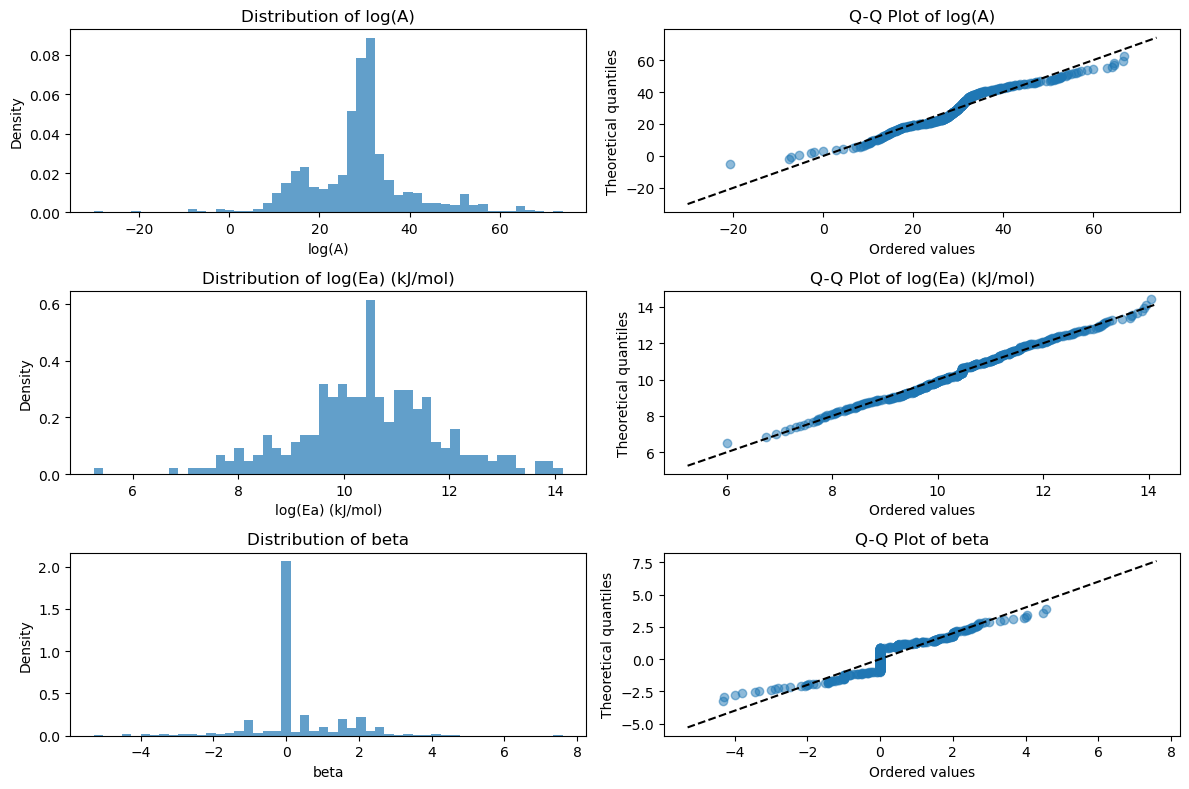

In [15]:
# checkout the distributions for each kinetic property - Ea, A, beta

properties = {
    "A": {"name": "log(A)", "transform": np.log, "filter": False},
    "Ea": {"name": "log(Ea) (kJ/mol)", "transform": np.log, "filter": True},
    "beta": {"name": "beta", "transform": lambda x: x, "filter": False}
}

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i, prop in enumerate(properties):
    if properties[prop]["filter"]:
        values = df[(df["H"] < 0) & (df[prop] > 0)][prop].dropna()
    else:
        values = df[prop].dropna()
    transformed_data = properties[prop]["transform"](values)
    axs[i, 0].hist(transformed_data, bins=50, density=True, alpha=0.7)
    axs[i, 0].set_title(f"Distribution of {properties[prop]['name']}")
    axs[i, 0].set_xlabel(properties[prop]["name"])
    axs[i, 0].set_ylabel("Density")

    dist = norm(np.mean(transformed_data), np.std(transformed_data))
    q = np.linspace(0, 100, 500)
    axs[i, 1].scatter(np.percentile(transformed_data, q), dist.ppf(q / 100), alpha=0.5)
    axs[i, 1].plot(np.percentile(transformed_data, q), np.percentile(transformed_data, q), color="k", linestyle="--")
    axs[i, 1].set_xlabel("Ordered values")
    axs[i, 1].set_ylabel("Theoretical quantiles")
    axs[i, 1].set_title(f"Q-Q Plot of {properties[prop]['name']}")
    print(properties[prop]["name"], round(np.mean(transformed_data), 4), round(np.std(transformed_data), 4), len(transformed_data))
plt.tight_layout()

Slope 1.2551e+00 Intercept 3.3500e+04 Error mean 1.6424e-10 Error STD 2.6644e+05 R^2 0.38


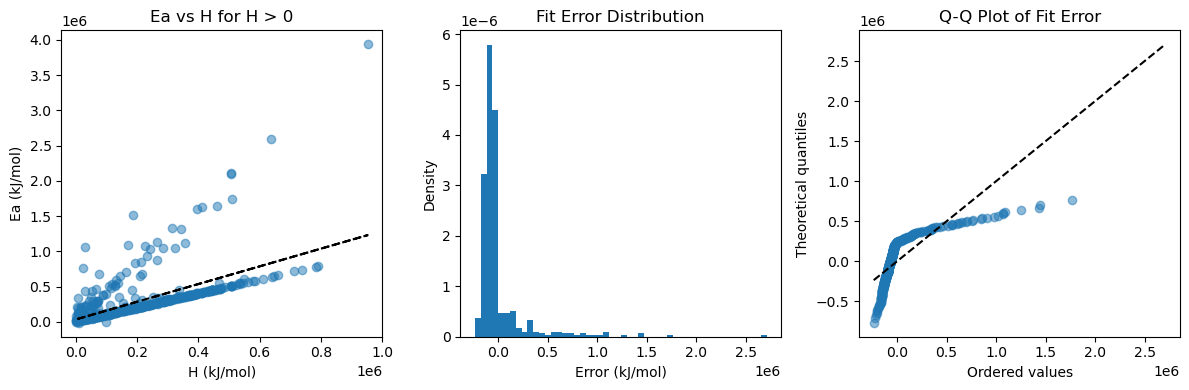

In [ ]:
from scipy import stats
# now check the situation for Ea when H > 0

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for ax in axs:
    ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
ajr = df[(df["H"] > 0)]
# scatter plot
axs[0].scatter(ajr["H"], ajr["Ea"], alpha=0.5)
a, b = np.polyfit(ajr["H"], ajr["Ea"], deg=1)
pred = a * ajr["H"] + b
axs[0].plot(ajr["H"], pred, color="k", linestyle="--");
axs[0].set_xlabel("H (kJ/mol)")
axs[0].set_ylabel("Ea (kJ/mol)")
axs[0].set_title("Ea vs H for H > 0")
# error distribution 
r = ajr["Ea"] - pred
axs[1].hist(r, bins=50, density=True);
q = np.linspace(0, 100, 500)
print("Slope", f"{a:.4e}", "Intercept", f"{b:.4e}", "Error mean", f"{np.mean(r):.4e}", "Error STD", f"{np.std(r):.4e}", "R^2", f"{stats.pearsonr(ajr['H'], ajr['Ea']).statistic ** 2:.2f}")
axs[1].set_xlabel("Error (kJ/mol)")
axs[1].set_ylabel("Density")
axs[1].set_title("Fit Error Distribution")
# q-q plot for error vs normal distribution
axs[2].scatter(np.percentile(r, q), norm(np.mean(r), np.std(r)).ppf(q / 100), alpha=0.5);
axs[2].plot(np.percentile(r, q), np.percentile(r, q), color="k", linestyle="--");
axs[2].set_xlabel("Ordered values")
axs[2].set_ylabel("Theoretical quantiles")
axs[2].set_title("Q-Q Plot of Fit Error")
plt.tight_layout()

